<a href="https://colab.research.google.com/github/eeolga/article/blob/main/3D_KLO2024_data_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import torch
import torch.nn as nn

In [33]:
import pandas as pd

In [34]:
CAD_path="/content/CAD_KLO_07082024.xlsx"

CAD_logs file data

In [35]:
data = pd.read_excel("/content/CAD_KLO_07082024.xlsx")

In [36]:
display(pd.DataFrame(data))

,timestamp,user_id,tool_id,competency,activity_id,date,time,lesson
0,"17/05/24, 13:10:11",29455,3299,2,20706,2024-05-17,13:10:11,1
1,"17/05/24, 13:10:11",29455,233156,2,20807,2024-05-17,13:10:11,1
2,"17/05/24, 13:09:51",29455,3299,2,20706,2024-05-17,13:09:51,1
3,"17/05/24, 13:09:49",29455,233156,2,20807,2024-05-17,13:09:49,1
4,"17/05/24, 13:02:38",29455,3299,2,20706,2024-05-17,13:02:38,1
...,...,...,...,...,...,...,...,...
5650,"9/02/24, 19:54:20",29455,2949,1,10103,2024-02-09,19:54:20,0
5651,"9/02/24, 19:53:27",29455,2949,1,10103,2024-02-09,19:53:27,0
5652,"9/02/24, 19:53:27",29455,2949,1,10102,2024-02-09,19:53:27,0
5653,"9/02/24, 19:53:27",29455,2949,1,10102,2024-02-09,19:53:27,0


Data model training


num_epochs = 100, lr=0.01, threshold = 0.5


Index(['timestamp', 'user_id', 'tool_id', 'competency', 'activity_id', 'date',
       'time', 'lesson'],
      dtype='object')
Non-numeric columns: Index(['timestamp', 'date', 'time'], dtype='object')
Epoch [10/100], Loss: 0.0714, Val Loss: 0.0639
Epoch [20/100], Loss: 0.0416, Val Loss: 0.0762
Epoch [30/100], Loss: 0.0425, Val Loss: 0.0872
Epoch [40/100], Loss: 0.0439, Val Loss: 0.0860
Epoch [50/100], Loss: 0.0446, Val Loss: 0.0844
Epoch [60/100], Loss: 0.0452, Val Loss: 0.0903
Epoch [70/100], Loss: 0.0456, Val Loss: 0.0889
Epoch [80/100], Loss: 0.0460, Val Loss: 0.0905
Epoch [90/100], Loss: 0.0464, Val Loss: 0.0917
Epoch [100/100], Loss: 0.0468, Val Loss: 0.0925


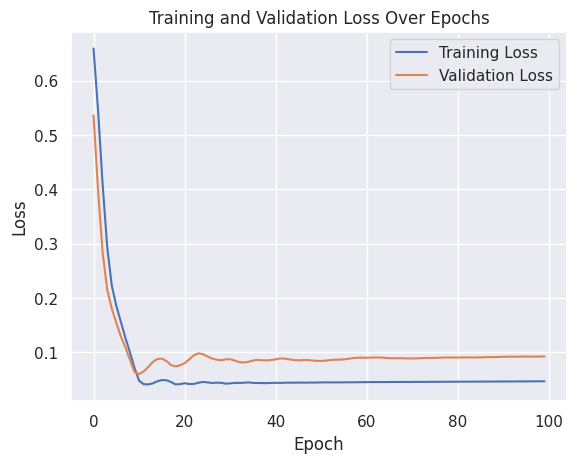

Raw outputs (first 10): tensor([9.9627e-01, 1.0000e+00, 1.6208e-08, 1.9226e-27, 1.0000e+00, 2.5644e-17,
        9.2111e-31, 1.0000e+00, 2.3002e-15, 5.3635e-31])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99       876
     class 1       0.96      1.00      0.98       255

    accuracy                           0.99      1131
   macro avg       0.98      0.99      0.99      1131
weighted avg       0.99      0.99      0.99      1131



In [37]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Load Data from Excel
file_path = '/content/CAD_KLO_07082024.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify 'competency' exists
print(data.columns)

# Assuming your Excel file has columns 'features' and 'target'
# Adjust 'competency' to the actual column name if necessary
X = data.drop('competency', axis=1)
y = data['competency'].values

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns (example: drop them)
X = X.drop(non_numeric_cols, axis=1).values

# Ensure target values are 0 or 1
y = (y == 1).astype(float)

#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the Model
num_epochs = 100
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Data model training


num_epochs = 200, lr=0.01, threshold = 0.5

Index(['timestamp', 'user_id', 'tool_id', 'competency', 'activity_id', 'date',
       'time', 'lesson'],
      dtype='object')
Non-numeric columns: Index(['timestamp', 'date', 'time'], dtype='object')
Epoch [20/200], Loss: 0.0426, Val Loss: 0.0787
Epoch [40/200], Loss: 0.0380, Val Loss: 0.0731
Epoch [60/200], Loss: 0.0405, Val Loss: 0.0807
Epoch [80/200], Loss: 0.0413, Val Loss: 0.0816
Epoch [100/200], Loss: 0.0421, Val Loss: 0.0835
Epoch [120/200], Loss: 0.0431, Val Loss: 0.0858
Epoch [140/200], Loss: 0.0444, Val Loss: 0.0887
Epoch [160/200], Loss: 0.0467, Val Loss: 0.0916
Epoch [180/200], Loss: 0.0465, Val Loss: 0.0932
Epoch [200/200], Loss: 0.0480, Val Loss: 0.0973


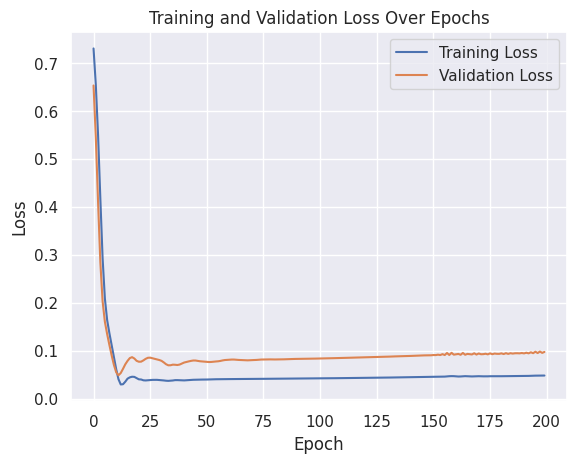

Raw outputs (first 10): tensor([9.9900e-01, 1.0000e+00, 1.4292e-11, 4.9988e-31, 1.0000e+00, 1.3556e-19,
        1.5976e-34, 1.0000e+00, 1.0059e-19, 9.7378e-35])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99       876
     class 1       0.96      1.00      0.98       255

    accuracy                           0.99      1131
   macro avg       0.98      0.99      0.99      1131
weighted avg       0.99      0.99      0.99      1131



In [38]:
# Load Data from Excel
file_path = '/content/CAD_KLO_07082024.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify 'competency' exists
print(data.columns)

# Assuming your Excel file has columns 'features' and 'target'
# Adjust 'competency' to the actual column name if necessary
X = data.drop('competency', axis=1)
y = data['competency'].values

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns (example: drop them)
X = X.drop(non_numeric_cols, axis=1).values

# Ensure target values are 0 or 1
y = (y == 1).astype(float)

#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the Model
num_epochs = 200
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Data model training


num_epochs = 300, lr=0.01, threshold = 0.5

Epoch [30/300], Loss: 0.2880, Val Loss: 0.2689
Epoch [60/300], Loss: 0.0551, Val Loss: 0.0597
Epoch [90/300], Loss: 0.0221, Val Loss: 0.0344
Epoch [120/300], Loss: 0.0183, Val Loss: 0.0315
Epoch [150/300], Loss: 0.0171, Val Loss: 0.0300
Epoch [180/300], Loss: 0.0163, Val Loss: 0.0290
Epoch [210/300], Loss: 0.0158, Val Loss: 0.0281
Epoch [240/300], Loss: 0.0154, Val Loss: 0.0274
Epoch [270/300], Loss: 0.0150, Val Loss: 0.0268
Epoch [300/300], Loss: 0.0146, Val Loss: 0.0263


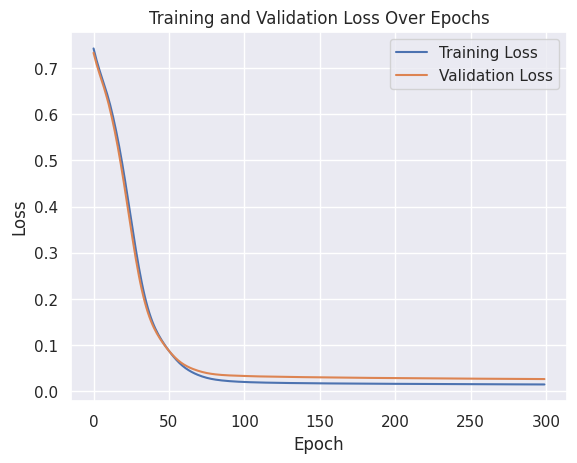

Raw outputs (first 10): tensor([9.7951e-01, 9.9932e-01, 3.2857e-04, 9.9688e-07, 9.9932e-01, 1.9057e-04,
        2.4715e-05, 9.9932e-01, 1.4449e-03, 2.4027e-05])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99       876
     class 1       0.96      1.00      0.98       255

    accuracy                           0.99      1131
   macro avg       0.98      0.99      0.99      1131
weighted avg       0.99      0.99      0.99      1131



In [39]:
#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 300
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 30 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Data model training


num_epochs = 500, criterion = nn.BCELoss, lr=0.01, threshold = 0.5

Epoch [50/500], Loss: 0.0743, Val Loss: 0.0742
Epoch [100/500], Loss: 0.0204, Val Loss: 0.0345
Epoch [150/500], Loss: 0.0183, Val Loss: 0.0323
Epoch [200/500], Loss: 0.0170, Val Loss: 0.0303
Epoch [250/500], Loss: 0.0160, Val Loss: 0.0284
Epoch [300/500], Loss: 0.0151, Val Loss: 0.0269
Epoch [350/500], Loss: 0.0144, Val Loss: 0.0258
Epoch [400/500], Loss: 0.0138, Val Loss: 0.0248
Epoch [450/500], Loss: 0.0133, Val Loss: 0.0241
Epoch [500/500], Loss: 0.0129, Val Loss: 0.0234


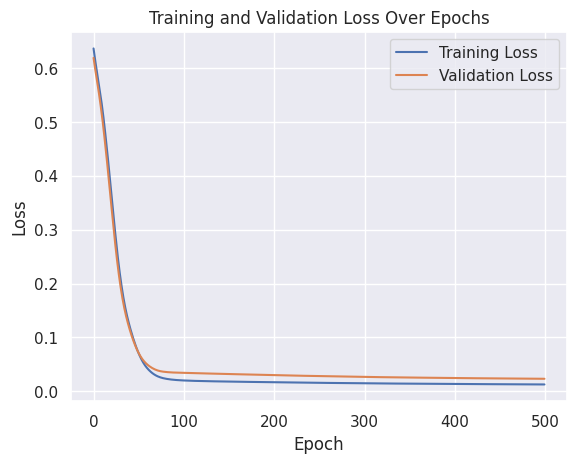

Raw outputs (first 10): tensor([9.8553e-01, 9.9963e-01, 5.4636e-05, 2.7287e-07, 9.9965e-01, 3.1583e-05,
        9.1642e-06, 9.9963e-01, 4.1591e-04, 9.1827e-06])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99       876
     class 1       0.96      1.00      0.98       255

    accuracy                           0.99      1131
   macro avg       0.98      0.99      0.99      1131
weighted avg       0.99      0.99      0.99      1131



In [40]:
#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the Model
num_epochs = 500
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Data model training

num_epochs = 900, criterion = nn.BCELoss, lr=0.01, threshold = 0.5

Epoch [90/1000], Loss: 0.0212, Val Loss: 0.0339
Epoch [180/1000], Loss: 0.0169, Val Loss: 0.0300
Epoch [270/1000], Loss: 0.0155, Val Loss: 0.0281
Epoch [360/1000], Loss: 0.0144, Val Loss: 0.0266
Epoch [450/1000], Loss: 0.0136, Val Loss: 0.0255
Epoch [540/1000], Loss: 0.0130, Val Loss: 0.0249
Epoch [630/1000], Loss: 0.0125, Val Loss: 0.0246
Epoch [720/1000], Loss: 0.0118, Val Loss: 0.0239
Epoch [810/1000], Loss: 0.0113, Val Loss: 0.0242
Epoch [900/1000], Loss: 0.0111, Val Loss: 0.0251
Epoch [990/1000], Loss: 0.0110, Val Loss: 0.0257


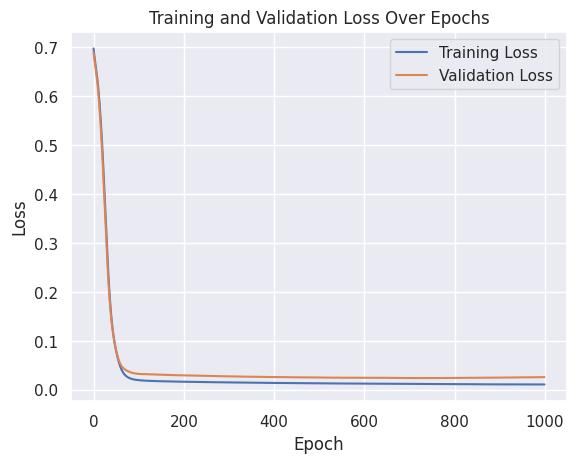

Raw outputs (first 10): tensor([9.9995e-01, 1.0000e+00, 7.6818e-06, 1.0230e-07, 1.0000e+00, 4.2774e-06,
        1.4891e-06, 1.0000e+00, 1.9532e-05, 1.4394e-06])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99       876
     class 1       0.97      1.00      0.98       255

    accuracy                           0.99      1131
   macro avg       0.98      0.99      0.99      1131
weighted avg       0.99      0.99      0.99      1131



In [42]:
#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the Model
num_epochs = 1000
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 90 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

The data model demonstrates stable learning ability when using standard hyperparameters.